In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from  statsmodels.tsa.stattools import adfuller,kpss 
import statsmodels.api
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.svm import SVR
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
#from hmmlearn import hmm

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
#format data
data=pd.read_csv('AMZN.csv')
data['Local time']=[data['Local time'][i].replace(' GMT+0300','')for i in range(len(data['Local time']))]
data['time']=[data['Local time'][i].replace('.','/',2)for i in range(len(data['Local time']))]
data['time']=[datetime.strptime(data['time'][i], '%d/%m/%Y %H:%M:%S.%f') for i in range(len(data['Local time']))]

In [3]:
#calculate midprice
data['Mid']=(data['Ask']+data['Bid'])/2
data['totalvolume']=data['AskVolume']+data['BidVolume']
#dat=data[['time','Mid']]
#dat.info()


In [4]:
#test for autocorrelation (Ljung-Box test of autocorrelation in residuals)
statsmodels.stats.diagnostic.acorr_ljungbox(data['Mid'])[1]
#there is autocorrelation present

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

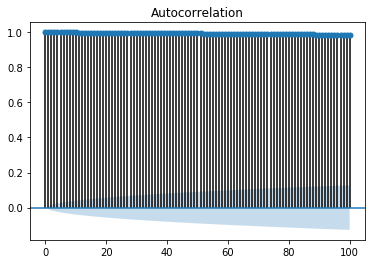

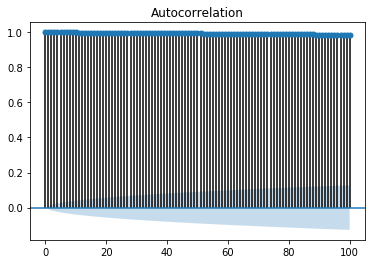

In [5]:
plot_acf(data['Mid'],lags=100)#no decrease in autocorrelation even after 100 lags
#slow decrease, does not converge to zero, a sign of non-stationarity

C:\Users\Dell\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


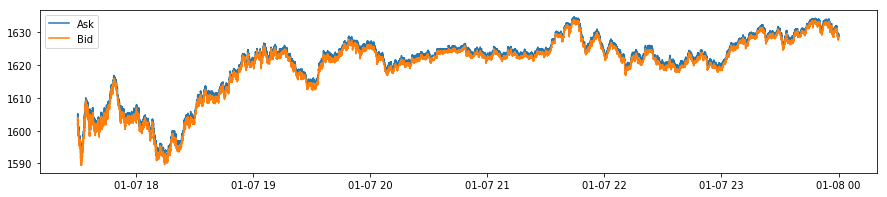

In [6]:
plt.figure(figsize=(15,3))
plt.plot(data['time'],data['Ask'])
plt.plot(data['time'],data['Bid'])
plt.legend()
plt.show()
#trend is obviuos, indicating varyinfg mean->non-stationary.Still, perform ADF and KPSS tests on stationarity

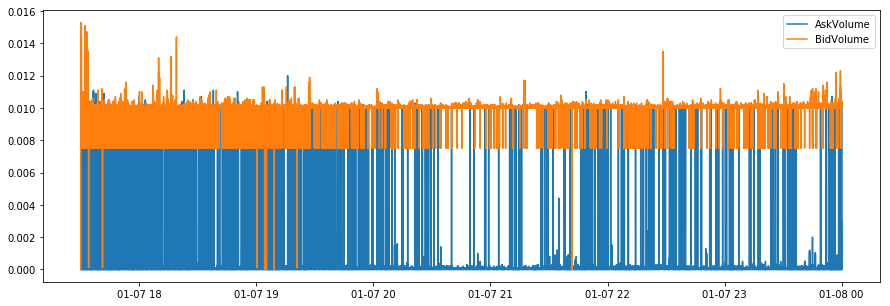

In [7]:
plt.figure(figsize=(15,5))
plt.plot(data['time'],data['AskVolume'])
plt.plot(data['time'],data['BidVolume'])
plt.legend()
plt.show()

In [8]:
data.index=pd.DatetimeIndex(data['time'])
data=data.drop(columns=['Local time'])
data.head(3)

,Ask,Bid,AskVolume,BidVolume,time,Mid,totalvolume
time,,,,,,,
2019-01-07 17:30:00.070,1603.113,1602.287,0.0001,0.0000,2019-01-07 17:30:00.070,1602.700,0.0001
2019-01-07 17:30:00.157,1604.452,1601.298,0.0001,0.0002,2019-01-07 17:30:00.157,1602.875,0.0003
2019-01-07 17:30:00.258,1604.453,1602.287,0.0002,0.0000,2019-01-07 17:30:00.258,1603.370,0.0002


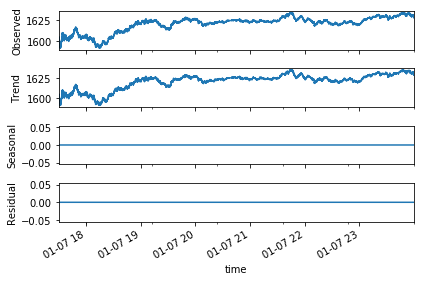

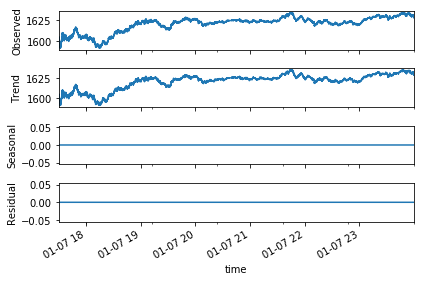

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose=seasonal_decompose(data[['Ask']],freq=1)
decompose.plot() #no seasonality or patterns

In [10]:
#midprice=np.array(dat['Mid'])
adfuller(data['Mid'],maxlag=7)
#p-value is 38%, so we detect non-stationarity

(-1.7997707426728153,
 0.38057551944593515,
 7,
 46549,
 {'1%': -3.430490489820316,
  '5%': -2.8616020935138544,
  '10%': -2.5668030503414685},
 -45848.89722598923)

In [11]:
#KPSS test
kpss(data['Mid'])
#p-value<1%, with 56 lags. So, this test tells that there is  nonstationarity (Ho:sationary)

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(54.7201516040537,
 0.01,
 56,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [12]:
delt=data.loc[:,'Mid']
delt=delt.diff(periods=1)
delt[0]=0
adfuller(delt,maxlag=7) #differencing removes non-stationarity, so work with new data

(-81.97771431870177,
 0.0,
 6,
 46550,
 {'1%': -3.4304904868021087,
  '5%': -2.8616020921799024,
  '10%': -2.566803049631444},
 -45847.65753760439)

In [13]:
data['delt']=delt
data.iloc[0,-1]=0
data.tail(3)

,Ask,Bid,AskVolume,BidVolume,time,Mid,totalvolume,delt
time,,,,,,,,
2019-01-07 23:59:59.771,1628.673,1628.149,0.0001,0.0102,2019-01-07 23:59:59.771,1628.4110,0.0103,-0.6145
2019-01-07 23:59:59.872,1629.462,1627.971,0.0100,0.0102,2019-01-07 23:59:59.872,1628.7165,0.0202,0.3055
2019-01-07 23:59:59.929,1629.462,1628.358,0.0000,0.0102,2019-01-07 23:59:59.929,1628.9100,0.0102,0.1935


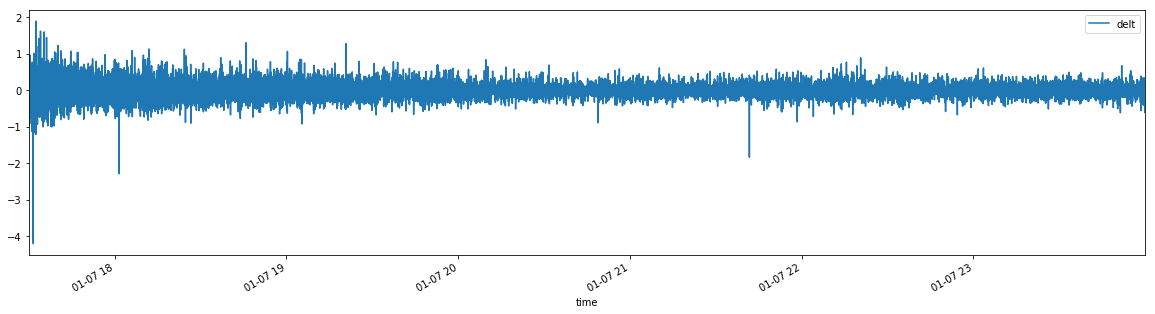

In [14]:
data.plot('time','delt',figsize=(20,5))

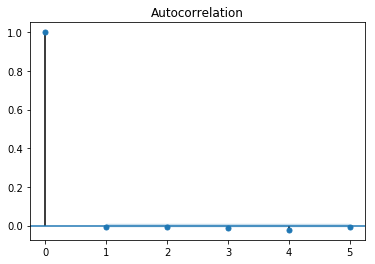

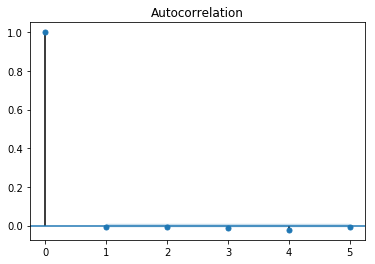

In [15]:
plot_acf(data['delt'],lags=5)#no autocorrelation between lags

In [16]:
#сделать новую дельту здесь с разницей вместо старой
from sklearn import preprocessing

date_range=list(range(len(delt)))

min_max_scaler = preprocessing.MinMaxScaler()
data_scaled=pd.DataFrame(min_max_scaler.fit_transform(np.array(data.drop(columns=['time']))))
data_scaled=pd.concat([data_scaled,pd.Series(date_range),pd.Series(np.ones(len(delt)))],axis=1)
data_scaled.columns=['Ask','Bid','AskVolume','BidVolume','Mid','totalvolume','delt','date_ind','intercept']
data_scaled=pd.concat([data_scaled,pd.Series(date_range)],axis=1)
data_scaled.head(3)
#min_max_scaler.transform(X_test)

,Ask,Bid,AskVolume,BidVolume,Mid,totalvolume,delt,date_ind,intercept,0
0,0.278112,0.289501,0.008333,0.000000,0.284150,0.003968,0.689381,0,1.0,0
1,0.308759,0.267285,0.008333,0.013072,0.288122,0.011905,0.718081,1,1.0,1
2,0.308782,0.289501,0.016667,0.000000,0.299357,0.007937,0.770562,2,1.0,2


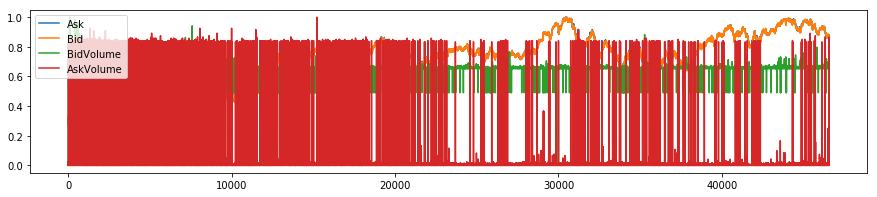

In [17]:
plt.figure(figsize=(15,3))
plt.plot(data_scaled['date_ind'],data_scaled['Ask'])
plt.plot(data_scaled['date_ind'],data_scaled['Bid'])
plt.plot(data_scaled['date_ind'],data_scaled['BidVolume'])
plt.plot(data_scaled['date_ind'],data_scaled['AskVolume'])
plt.legend()
plt.show()

In [18]:
#data['time']=str(data['time'])

#data_for_split=pd.DataFrame([date_range,pd.Series(np.ones(len(delt))),data_scaled['AskVolume'],data['BidVolume'],data['delt']],)

In [19]:
#test and trainings sets for delta
data_for_split=data_scaled[['Ask','delt',]]
data_for_split.columns=[['Ask','delt',]]
tss = TimeSeriesSplit(n_splits = 2)
X=data_for_split[['Ask']]
Y=data_for_split[['delt']]
for train_index, test_index in tss.split(X):
    xtrain, xtest = X.iloc[train_index, :], X.iloc[test_index,:]
    ytrain, ytest = Y.iloc[train_index], Y.iloc[test_index]
    
xtraindel=np.array(xtrain)
xtraindel=xtraindel.reshape(xtraindel.shape[0],xtraindel.shape[1])
ytraindel=np.array(ytrain).reshape(ytrain.shape[0],)
xtestdel=np.array(xtest).reshape(xtest.shape[0],xtest.shape[1])
ytestdel=np.array(ytest).reshape(ytest.shape[0],)


In [20]:
#test and trainings sets for price
#data_splt=pd.DataFrame([date_range,pd.Series(np.ones(len(delt))),data['AskVolume'],data['BidVolume'],data['Mid']],)
data_splt=data_scaled[['Ask','Bid',]]
data_splt.columns=['Ask','Bid']
tss = TimeSeriesSplit(n_splits = 5)
X1=data_splt[['Ask']]
Y1=data_splt[['Bid']]
for train_index, test_index in tss.split(X):
    xtrainmid, xtestmid = X1.iloc[train_index, :], X1.iloc[test_index,:]
    ytrainmid, ytestmid = Y1.iloc[train_index], Y1.iloc[test_index]
    
    xtrainmid=np.array(xtrainmid)
    xtrainmid=xtrainmid.reshape(xtrainmid.shape[0],xtrainmid.shape[1])
    ytrainmid=np.array(ytrainmid).reshape(ytrainmid.shape[0],)
    xtestmid=np.array(xtestmid).reshape(xtestmid.shape[0],xtestmid.shape[1])
    ytestmid=np.array(ytestmid).reshape(ytestmid.shape[0],)


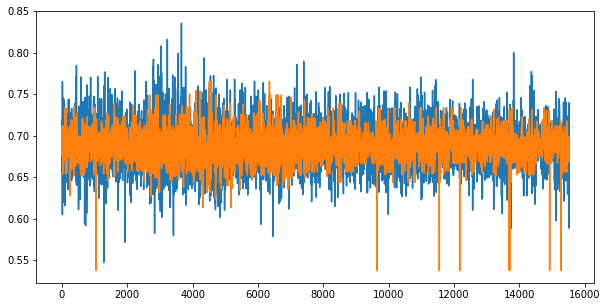

-19.7456116517959


In [22]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(xtraindel, ytraindel)
plt.figure(figsize=(10,5))
plt.plot(ytestdel)
plt.plot(knn.predict(xtestdel))
plt.show()
print(knn.score(xtestmid,ytestmid))

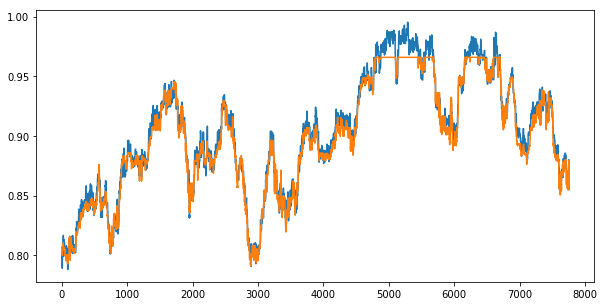

0.9765455916886967


In [23]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1000)
knn.fit(xtrainmid, ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(knn.predict(xtestmid))
plt.show()
print(knn.score(xtestmid,ytestmid))

In [ ]:
#for k in ['linear','poly','rbf','sigmoid']:
 #   clf = SVR(kernel=k)
  #  clf.fit(xtrainmid, ytrainmid)
   # confidence = clf.score(xtrainmid, ytrainmid)
   # print(k,confidence)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


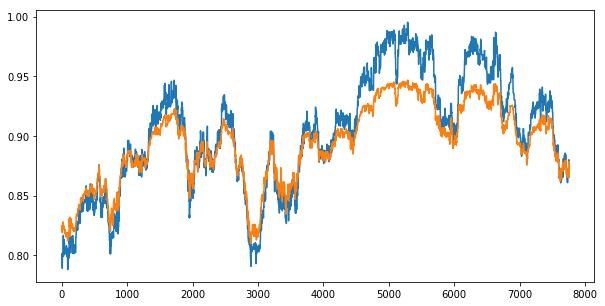

0.8548102747072566


In [24]:
Svr=SVR(C=9.0, epsilon=0.05)
Svr.fit(xtrainmid, ytrainmid)
#print(Svr.score(regr, date))
#Svr.predict()
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(Svr.predict(xtestmid))
plt.show()
print(Svr.score(xtestmid,ytestmid))

In [ ]:
HMM= hmm.GaussianHMM(3, "full")
HMM.fit(xtrainmid)

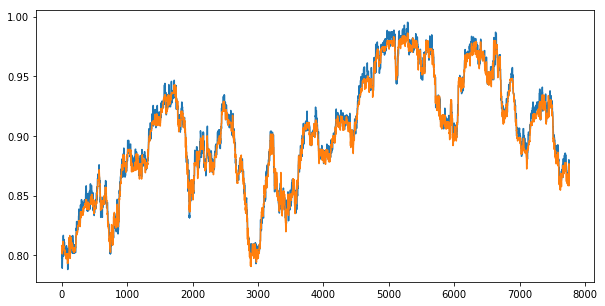

0.9879174265802075


In [25]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(xtrainmid,ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(lin.predict(xtestmid))
plt.show()
print(lin.score(xtestmid,ytestmid))

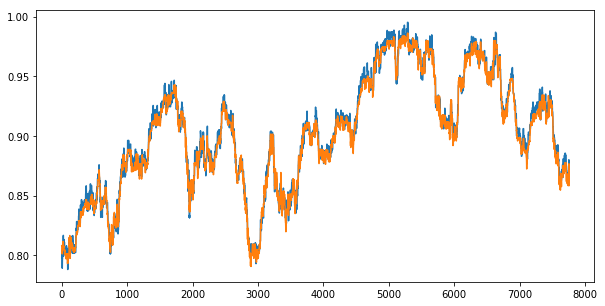

0.987917424613085


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
alphas = np.logspace(-5,3,20)

clf = GridSearchCV(estimator=linear_model.Ridge(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(xtrainmid,ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(clf.predict(xtestmid))
plt.show()
print(clf.score(xtestmid,ytestmid))

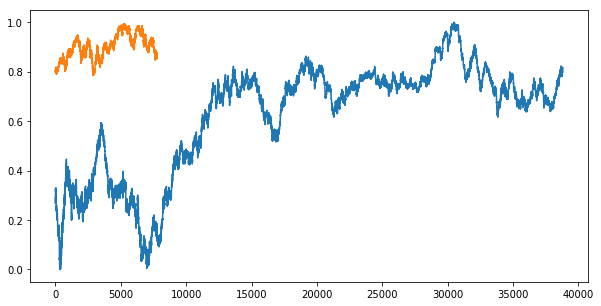

0.9800229321028624


In [27]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2)
# Train the model on training data
rf.fit(xtrainmid,ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytrainmid)
plt.plot(rf.predict(xtestmid))
plt.show()
print(rf.score(xtestmid,ytestmid))